## Library

In [132]:
# ====================================================
# Library
# ====================================================

import os
import copy
import time
from random import randrange, randint

import cv2
from PIL import Image

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from skimage import io
from sklearn.metrics import confusion_matrix

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline
#%matplotlib notebook

import timm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from torch.optim import SGD, Adam
from torch.optim import lr_scheduler

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'working with {device}')


working with cuda


## Import train csv

In [133]:
PATH = '/home/nico/Desktop/MarieCurie/Flowcam/train/'

train = pd.read_csv(PATH + 'train.csv')

Ntrain, Nval = 400, 400#400, 400#1000, 1000#400, 80 #200,40

camp_train, camp_val = train.loc[train['camp'] == 1].sample(Ntrain), train.loc[train['camp'] == 1].sample(Nval)
corylus_train, corylus_val = train.loc[train['corylus'] == 1].sample(Ntrain), train.loc[train['corylus'] == 1].sample(Nval)
dust_train, dust_val = train.loc[train['dust'] == 1].sample(Ntrain), train.loc[train['dust'] == 1].sample(Nval)
grim_train, grim_val = train.loc[train['grim'] == 1].sample(Ntrain), train.loc[train['grim'] == 1].sample(Nval)
qrob_train, qrob_val = train.loc[train['qrob'] == 1].sample(Ntrain), train.loc[train['qrob'] == 1].sample(Nval)
qsub_train, qsub_val = train.loc[train['qsub'] == 1].sample(Ntrain), train.loc[train['qsub'] == 1].sample(Nval)


train = pd.concat([camp_train, corylus_train, dust_train, grim_train, qrob_train, qsub_train], ignore_index = True)
val = pd.concat([camp_val, corylus_val, dust_val, grim_val, qrob_val, qsub_val], ignore_index = True)

print(len(train))
print(len(val))

display(train.sample(3))

2400
2400


,Particle ID,Area (ABD),Area (Filled),Aspect Ratio,Biovolume (Cylinder),Biovolume (P. Spheroid),Biovolume (Sphere),Calibration Factor,Calibration Image,Camera,...,Volume (ABD),Volume (ESD),Width,imgpaths,camp,corylus,dust,grim,qrob,qsub
17,247,1002.83,1176.91,0.29,13671.54,17192.64,23889.35,0.2752,1,1,...,23889.350000,74299.070000,21.32,/home/nico/Desktop/MarieCurie/Flowcam/train/ca...,1,0,0,0,0,0
443,1,480.38,504.84,0.94,8863.47,8535.98,7920.22,0.2752,1,1,...,7920.224000,9436.425000,25.31,/home/nico/Desktop/MarieCurie/Flowcam/train/co...,0,1,0,0,0,0
1010,5735,4.11,4.11,0.77,16.84,5.05,6.28,0.2752,3,1,...,6.275891,7.797889,2.01,/home/nico/Desktop/MarieCurie/Flowcam/train/du...,0,0,1,0,0,0


### Size distribution

0.28 8.12
5.0 57.79
5.0 103.26
12.45 43.54
5.71 54.51
5.19 53.02


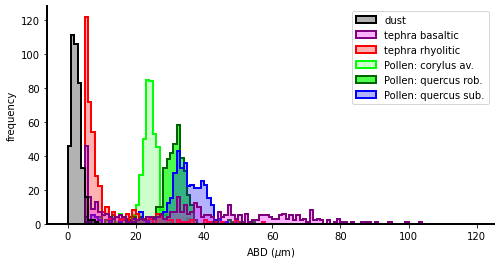

In [134]:
fig = plt.figure(figsize=(8, 4), linewidth=0, edgecolor='k')

ax0 = fig.add_subplot(1,1,1)

bins = np.arange(0, 120, 1) 


print(dust_train['Diameter (ABD)'].min(), dust_train['Diameter (ABD)'].max())
print(camp_train['Diameter (ABD)'].min(), camp_train['Diameter (ABD)'].max())
print(grim_train['Diameter (ABD)'].min(), grim_train['Diameter (ABD)'].max())
print(corylus_train['Diameter (ABD)'].min(), corylus_train['Diameter (ABD)'].max())
print(qrob_train['Diameter (ABD)'].min(), qrob_train['Diameter (ABD)'].max())
print(qsub_train['Diameter (ABD)'].min(), qsub_train['Diameter (ABD)'].max())

bY_dust, bX_dust, _ = ax0.hist(dust_train['Diameter (ABD)'], bins=bins, label='dust', align='mid', histtype='stepfilled', ec='k', lw=2, fc=(0, 0, 0, 0.3), zorder=6)
bY_grim, bX_grim, _ = ax0.hist(grim_train['Diameter (ABD)'], bins=bins, label='tephra basaltic', align='mid', histtype='stepfilled', ec='purple', lw=2, fc=(1, 0, 1, 0.3), zorder=5)
bY_camp, bX_camp, _ = ax0.hist(camp_train['Diameter (ABD)'], bins=bins, label='tephra rhyolitic', align='mid', histtype='stepfilled', ec='red', lw=2, fc=(1, 0, 0, 0.3), zorder=4)
bY_cor, bX_cor, _ = ax0.hist(corylus_train['Diameter (ABD)'], bins=bins, label='Pollen: corylus av.', align='mid', histtype='stepfilled', ec='lime', lw=2, fc=(0, 1, 0, 0.2))
bY_qrob, bX_qrob, _ = ax0.hist(qrob_train['Diameter (ABD)'], bins=bins, label='Pollen: quercus rob.', align='mid', histtype='stepfilled', ec='darkgreen', lw=2, fc=(0, 1, 0, 0.7))
bY_qsub, bX_qsub, _ = ax0.hist(qsub_train['Diameter (ABD)'], bins=bins, label='Pollen: quercus sub.', align='mid', histtype='stepfilled', ec='blue', lw=2, fc=(0, 0, 1, 0.3))


ax0.set(title='', ylabel='frequency', xlabel='ABD ($\mu$m)')

ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_linewidth(2)
ax0.spines['bottom'].set_linewidth(2)

ax0.legend(loc='best')


## Show distribution of labels

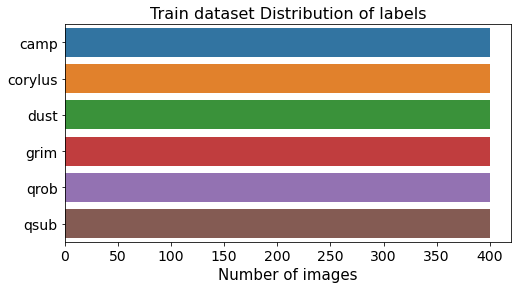

In [135]:
plt.figure(figsize=(8, 4))
df_tmp = train.iloc[:, -6:].sum()
sns.barplot(x=df_tmp.values, y=df_tmp.index)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Number of images", fontsize=15)
plt.title("Train dataset Distribution of labels", fontsize=16);


## Show something

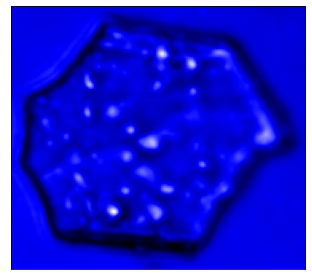

In [302]:
def show_image(df, n):
    imgpath = df.loc[n, 'imgpaths']
    img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    fig, ax = plt.subplots()
    ax.imshow(img, 
           cmap=matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap',  ['black','blue','white'],256))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()


camp = train[train['camp']==True]
camp.reset_index(inplace=True)


show_image(camp, n=randint(0, len(camp)))

## CFG

In [305]:
# ====================================================
# CFG
# ====================================================
class CFG:
    target_size = 6
    target_cols = ['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub']
    size = 1000#256#1000
    n_fold = 4
    num_workers = 8
    batch_size = 8
    model_name='resnet18' #'resnet18' #'resnext50_32x4d'
    if_pretrained = True
    
    lr=1e-2
    
    epochs = 15
    
    save_model = False
    OUTPUT_DIR = 'pytorch_saved_model/'

## CV split

In [138]:
# For future implementation ... explore Kfolds, StatifiedKfolds, GroupKfolds..

## Dataset class

In [139]:
# ====================================================
# Dataset
# ====================================================
class ParticleDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.img_paths = df['imgpaths'].to_numpy()
        self.labels = df[CFG.target_cols].to_numpy()
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_path = self.img_paths[idx]
        
        # Using cv2 (the problem is that torchvision transforms.Compose need a PIL image)
        image = cv2.imread(img_path)#, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = transforms.ToPILImage()(image)
        
        # Using PIL
        #image = Image.open(img_path)
                    
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        label = torch.tensor(self.labels[idx]).float()
        return image, label, img_path

## Transforms

In [140]:
# ====================================================
# Transforms
# 2 ways. torchvision transforms or Albumentations.
# Data augmentation and normalization for training
# Just normalization for validation
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':      
        return A.Compose([
            A.Flip(p=0.5),
            #A.Resize(CFG.size, CFG.size),
            A.Normalize(mean=[0.4071571, 0.4071571, 0.4071571], std=[0.10520694, 0.10520694, 0.10520694]),
            A.PadIfNeeded(min_height=CFG.size, min_width=CFG.size, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
            #A.Resize(512, 512),
            #A.LongestMaxSize(max_size=512),
            #A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
            ToTensorV2()
        ])

    elif data == 'valid':
        # Note that transformations on valid set cannot be random. They have to be deterministic.
        return A.Compose([
            #A.Resize(CFG.size, CFG.size),
            A.Normalize(mean=[0.4071571, 0.4071571, 0.4071571], std=[0.10520694, 0.10520694, 0.10520694]),
            A.PadIfNeeded(min_height=CFG.size, min_width=CFG.size, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
            #A.Resize(512, 512),
            #A.LongestMaxSize(max_size=512),
            #A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
            ToTensorV2()
        ])

## Load data

/home/nico/Desktop/MarieCurie/Flowcam/train/grimsvotn/grim_16nov_2_fc80_20x_307.png


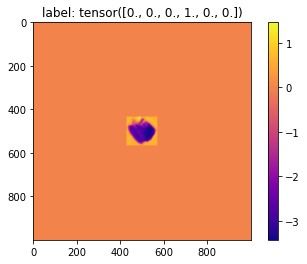

/home/nico/Desktop/MarieCurie/Flowcam/train/corylus/corylus_4nov_17_fc80_20x_1.png


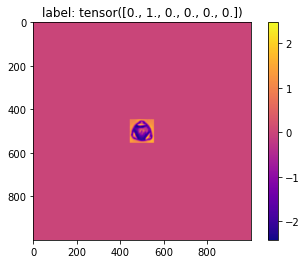

/home/nico/Desktop/MarieCurie/Flowcam/train/grimsvotn/grim_13nov_4_fc80_20x_445.png


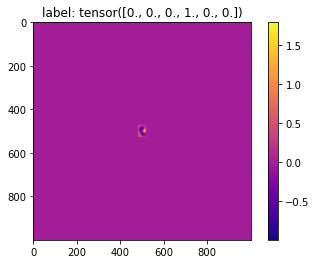

/home/nico/Desktop/MarieCurie/Flowcam/train/corylus/corylus_6nov_6_fc80_20x_86.png


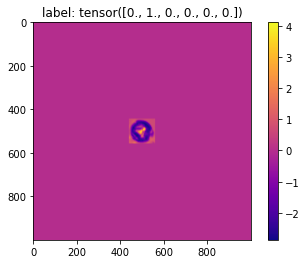

/home/nico/Desktop/MarieCurie/Flowcam/train/qsuber/qsub_17nov_1_fc80_20x_2676.png


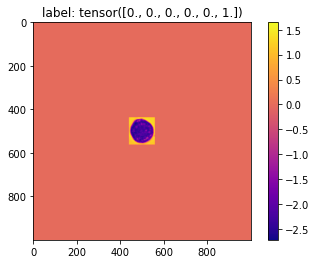

/home/nico/Desktop/MarieCurie/Flowcam/train/corylus/corylus_6nov_9_fc80_20x_263.png


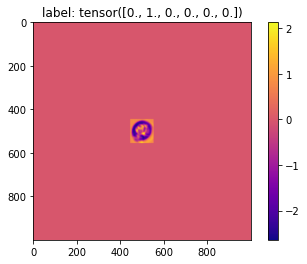

/home/nico/Desktop/MarieCurie/Flowcam/train/corylus/corylus_6nov_3_fc80_20x_120.png


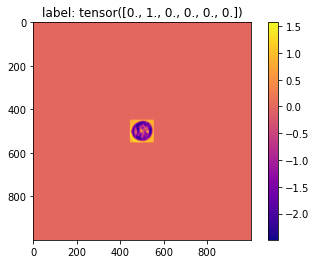

/home/nico/Desktop/MarieCurie/Flowcam/train/dust/std12ppm__28oct_5_fc80_20x_2869.png


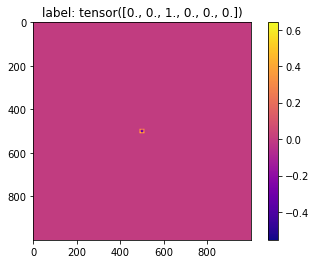

/home/nico/Desktop/MarieCurie/Flowcam/train/dust/std12ppm__28oct_2_fc80_20x_6031.png


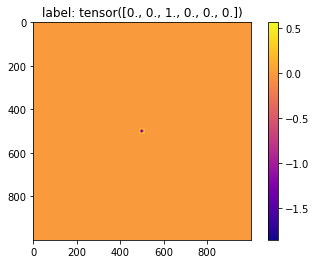

/home/nico/Desktop/MarieCurie/Flowcam/train/grimsvotn/grim_16nov_2_fc80_20x_1101.png


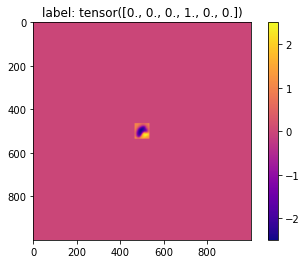

In [141]:
train_dataset = ParticleDataset(train, transform=get_transforms(data='train'))
valid_dataset = ParticleDataset(val, transform=get_transforms(data='valid'))

#train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [1000, 200])

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size * 2, shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


dataloaders = {'train': train_loader, 'val': valid_loader}

dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}

# Plot something
ifplot = True
if ifplot is True:
    for i in range(10):
        N = len(train_dataset) 
        n = randrange(N)
        image, label, path = train_dataset[n]
        print(path)
        plt.imshow(image[2,:,:], cmap='plasma')
        plt.colorbar()
        plt.title(f'label: {label}')
        plt.show()

        

    

## Functions

In [142]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.history = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.history.append(self.sum / self.count)
        
    def update_simplesum(self, val, n=1):
        self.val = val
        self.sum += val
        self.count += n
        self.avg = self.sum / self.count
        self.history.append(self.sum / self.count)



def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    losses = AverageMeter()
    accuracies = AverageMeter()
    
    model.train()
    
    running_corrects = 0
    
    for step, (images, labels, paths) in enumerate(train_loader):
        
        images = images.to(device) 
        labels = labels.to(device)    
        
        #with torch.set_grad_enabled(True):
        y_preds = model(images) 
        loss = criterion(y_preds, labels)
        preds = (y_preds == y_preds.max(dim=1, keepdim=True)[0]).to(dtype=torch.int32)
        
        # statistics
        losses.update(loss.item(), images.size(0))     
        how_many_correct = torch.sum(torch.all(torch.eq(preds, labels), dim=1))      
        accuracies.update_simplesum(how_many_correct.item(), images.size(0))
        
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        
    scheduler.step()  
    
    print(f'Train Loss: {losses.avg:.4f} Acc: {accuracies.avg:.4f}')

    return losses.history, accuracies.history


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    accuracies = AverageMeter()

    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    for step, (images, labels, paths) in enumerate(valid_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels) #inside here?
            preds = (y_preds == y_preds.max(dim=1, keepdim=True)[0]).to(dtype=torch.int32)
        
        # statistics        
        losses.update(loss.item(), images.size(0))
        how_many_correct = torch.sum(torch.all(torch.eq(preds, labels), dim=1)) 
        accuracies.update_simplesum(how_many_correct.item(), images.size(0))
        
        #running_loss += loss.item() * images.size(0)
        #running_corrects += torch.sum(torch.all(torch.eq(preds, labels), dim=1))
     
    #epoch_loss = running_loss / len(val)
    #epoch_acc = running_corrects.double() / len(val)
    #print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    print(f'Val Loss: {losses.avg:.4f} Acc: {accuracies.avg:.4f}')

    return losses.history, accuracies.history



## Model

In [143]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=CFG.if_pretrained):
        
        super().__init__()
            
        if model_name == 'resnet18':
            self.model = models.resnet18(pretrained=CFG.if_pretrained)
        elif model_name == 'resnext50_32x4d':
            self.model = timm.create_model(model_name, pretrained=CFG.if_pretrained)
        
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)
        
        print(f'Model: {model_name}')

    def forward(self, x):
        x = self.model(x)
        return x



## Train loop

In [306]:
def train_loop():
    
    train_dataset = ParticleDataset(train, transform=get_transforms(data='train'))
    valid_dataset = ParticleDataset(val, transform=get_transforms(data='valid'))


    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    
    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=CFG.if_pretrained)
    
    model.to(device)

    optimizer = SGD(model.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True)
    
    # Decay LR by a factor of 0.1 every step_size epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    criterion = nn.BCEWithLogitsLoss()
    
    #model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=2)  
    #return model
    
    # ====================================================
    # loop
    # ====================================================
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_history = []
    train_acc_history = []
    
    val_loss_history = []
    val_acc_history = []

    
    for epoch in range(CFG.epochs):
        print(f'-'*10)
        print(f'Epoch {epoch}/{CFG.epochs - 1}')
        
        # train
        train_epoch_loss_history, train_epoch_acc_history = train_fn(train_loader, model, criterion, optimizer, 
                                             epoch, exp_lr_scheduler, device)
        
        train_loss_history += train_epoch_loss_history
        train_acc_history += train_epoch_acc_history
       
                
        # val
        val_epoch_loss_history, val_epoch_acc_history = valid_fn(valid_loader, model, criterion, device)
        
        val_loss_history += val_epoch_loss_history
        val_acc_history += val_epoch_acc_history
        
        
        # If epoch validation accuracy has improved, deep copy the model
        if np.mean(val_epoch_acc_history) > best_acc:
            best_acc = np.mean(val_epoch_acc_history)
            best_model_wts = copy.deepcopy(model.state_dict())
            
        
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, model
    
    

train_loss_history, train_acc_history, val_loss_history, val_acc_history, model = train_loop()


Model: resnet18
----------
Epoch 0/14
Train Loss: 0.3020 Acc: 0.6092
Val Loss: 0.1735 Acc: 0.7887
----------
Epoch 1/14
Train Loss: 0.2024 Acc: 0.7592
Val Loss: 0.1879 Acc: 0.7808
----------
Epoch 2/14
Train Loss: 0.1708 Acc: 0.7979
Val Loss: 0.1424 Acc: 0.8137
----------
Epoch 3/14
Train Loss: 0.1511 Acc: 0.8271
Val Loss: 0.1851 Acc: 0.7746
----------
Epoch 4/14
Train Loss: 0.1387 Acc: 0.8387
Val Loss: 0.1388 Acc: 0.8333
----------
Epoch 5/14
Train Loss: 0.1320 Acc: 0.8450
Val Loss: 0.1129 Acc: 0.8579
----------
Epoch 6/14
Train Loss: 0.1233 Acc: 0.8546
Val Loss: 0.1410 Acc: 0.8208
----------
Epoch 7/14
Train Loss: 0.1041 Acc: 0.8817
Val Loss: 0.1068 Acc: 0.8658
----------
Epoch 8/14
Train Loss: 0.0967 Acc: 0.8900
Val Loss: 0.1049 Acc: 0.8654
----------
Epoch 9/14
Train Loss: 0.0908 Acc: 0.8996
Val Loss: 0.0989 Acc: 0.8762
----------
Epoch 10/14
Train Loss: 0.0869 Acc: 0.9042
Val Loss: 0.1022 Acc: 0.8688
----------
Epoch 11/14
Train Loss: 0.0864 Acc: 0.9029
Val Loss: 0.0980 Acc: 0.880

## Model performance

4500 4500
4500 4500


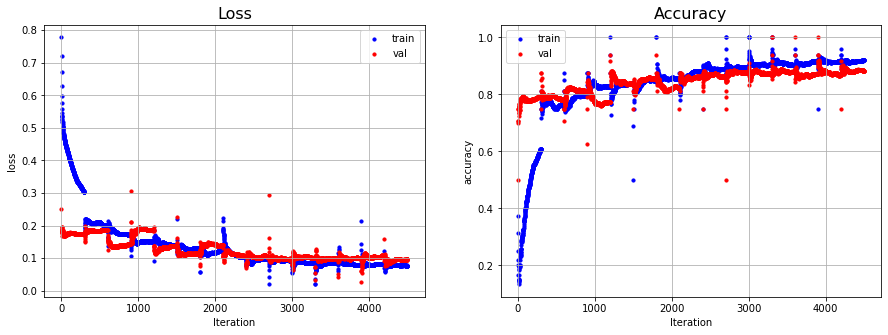

In [307]:
print(len(train_loss_history), len(val_loss_history))
print(len(train_acc_history), len(val_acc_history))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

t = np.arange(0, len(train_loss_history), 1)

ax1.scatter(t, train_loss_history, s=10, c='b', label='train')
ax1.scatter(t, val_loss_history, s=10, c='r', label='val')
#ax1.plot(t, pd.Series(train_loss_history).rolling(20, min_periods=1, center=True).mean(), c='blue')
ax1.set(xlabel='Iteration', ylabel='loss')
ax1.set_title('Loss', fontsize=16)
ax1.legend()
ax1.grid()

ax2.scatter(t, train_acc_history, s=10, c='b', label='train')
ax2.scatter(t, val_acc_history, s=10, c='r', label='val')
ax2.set(xlabel='Iteration', ylabel='accuracy')
ax2.set_title('Accuracy', fontsize=16)
ax2.legend()
ax2.grid()



## Scan val dataset and return results

In [308]:
def scan_val_dataset(model):
    
    print('Start a forward pass on validation dataset...')
    start = time.time()
        
    model.eval()
    
    # Initialize val dataset and dataloader
    valid_dataset = ParticleDataset(val, transform=get_transforms(data='valid'))   
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # Initialize a dictionary of results
    results_val = {'paths': [], 'preds': np.array([]), 'labels': np.array([])}
    
    
    with torch.no_grad():
        for i, (images, labels, paths) in enumerate(valid_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            y_preds = model(images)
            preds = (y_preds == y_preds.max(dim=1, keepdim=True)[0]).to(dtype=torch.int32)
            
            pred_indexes = torch.max(preds, 1)[1].cpu().numpy()        
            label_indexes = torch.max(labels, 1)[1].cpu().numpy()
            
            #print('y_preds', y_preds)
            #print('preds',preds)
            #print('preds indexes', pred_indexes)
            #print('labels',labels)
            #print('labels indexes',label_indexes)         
            #print('paths',paths)

            
            # Fill dictionary with validation dataset results
            results_val['paths'] += paths
            results_val['preds'] = np.concatenate((results_val['preds'], pred_indexes), axis=0)
            results_val['labels'] = np.concatenate((results_val['labels'], label_indexes), axis=0)
            
                                          
        
    print(f'Finished in {time.time()-start:.2f} sec.')
        
    return results_val
    
results_val = scan_val_dataset(model)

Start a forward pass on validation dataset...
Finished in 13.57 sec.


## Show some results and confusion matrix
NB: would be interesting to show the misclassified items, i.e. those for which pred != label

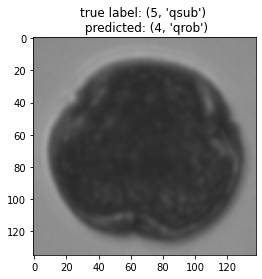

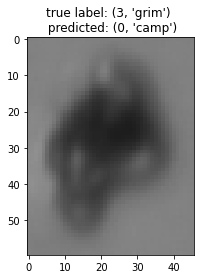

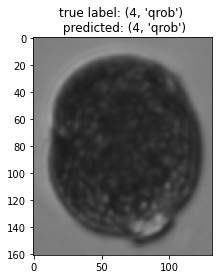

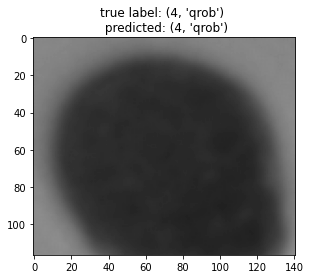

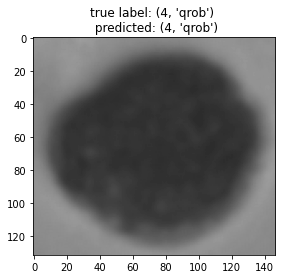

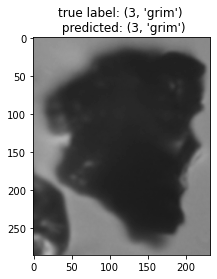

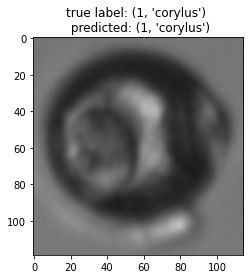

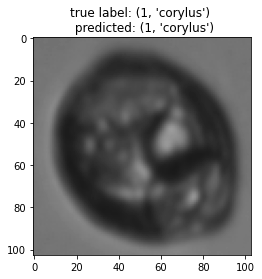

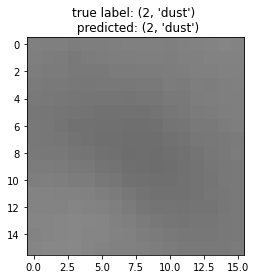

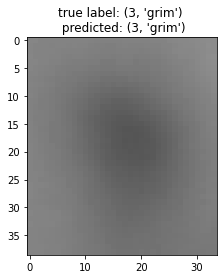

Confusion matrix: 
 [[356   0  10  33   1   0]
 [  3 395   0   0   1   1]
 [  7   0 391   2   0   0]
 [ 64   0  12 320   2   2]
 [  2   1   1   2 355  39]
 [  1   3   0   4  95 297]]
validation accuracy: 0.8808


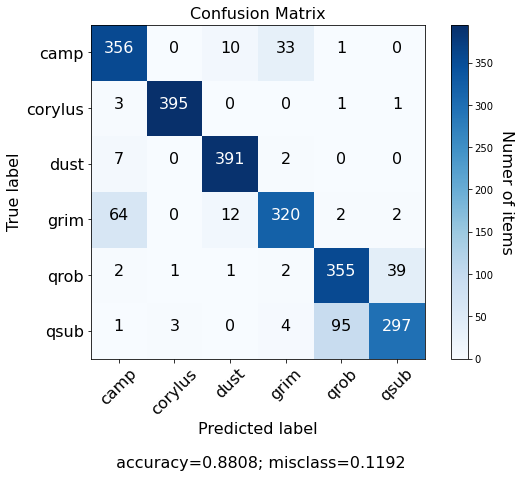

In [309]:
# Show some random results
if_show = True
if if_show:
    for i in range(10):
        N = len(results_val['paths']) 
        n = randrange(N)

        path = results_val['paths'][n]
        pred = results_val['preds'][n]
        label = results_val['labels'][n]

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)    
        plt.title(f'true label: {int(label), CFG.target_cols[int(label)]} \n predicted: {int(pred), CFG.target_cols[int(pred)]}')

        plt.show()



# Confusion matrix function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')#Blues#summer

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    cbar = plt.colorbar()
    
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=16)
        plt.yticks(tick_marks, target_names, fontsize=16)
        

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=13,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=16,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel(f'Predicted label\n\n accuracy={accuracy:0.4f}; misclass={misclass:0.4f}', fontsize=16)
    cbar.ax.set_ylabel('Numer of items',  labelpad=20, rotation=270, fontsize=16)   
    plt.show()
    
    
    
cm = confusion_matrix(results_val['labels'], results_val['preds'])
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
print(f'Confusion matrix: \n {cm}')
print(f'validation accuracy: {accuracy:.4f}')


plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = CFG.target_cols,
                      title        = "Confusion Matrix")

### 